<img src="./logo_UNSAM.jpg" align="right" width="150" />  -->

#### Análisis y procesamiento de señales

# Trabajo Práctico Nº8
#### Santiago Manuel Corral

# Introducción

En este trabajo se estudian y aplican diversas técnicas de procesamiento digital de señales para la mejora de registros electrocardiográficos (ECG), con especial énfasis en la atenuación del movimiento de línea de base y la detección de eventos cardíacos. La señal ECG es altamente sensible a interferencias de muy baja frecuencia (<0.5 Hz), que pueden dificultar el análisis de los complejos QRS, cruciales para el diagnóstico clínico.

En primer lugar, se implementaron dos estrategias no lineales para estimar y sustraer el movimiento de línea de base: 

- Filtrado mediante mediana encadenada (ventanas de 200 ms seguido de 600 ms):
Dado un conjunto de muestras de una señal $s[n]$, el filtro de mediana reemplaza cada muestra por el valor mediano (no el promedio, ya que este no resulta tan robusto) de un conjunto de muestras vecinas, es decir, una ventana deslizante centrada en $n$.

- Interpolación por splines cúbicos a partir de regiones isoeléctricas previas a los complejos QRS.
Un spline cúbico es una función compuesta por segmentos de polinomios de grado 3 (cúbicos) que se ajustan entre pares de puntos conocidos, de modo que la función resultante: Interpola los puntos dados (pasa por ellos) y es suave.

Además, se diseñó un detector de latidos basado en un filtro adaptado, empleando el patrón del complejo QRS provisto como plantilla. 
Aplicar un filtro adaptado consiste en correlar la señal ECG con el patrón $h[n]$, que es una versión invertida y desplazada del QRS. 

$$
y[n] = \sum_{k=0}^{N-1} s[k] \cdot h[n + k]
$$


Por lo que entonces el resultado $y[n]$ tendrá picos donde la forma del QRS coincida con la señal original. Se aplican técnicas de detección de picos (scipy.signal.find_peaks) sobre $y[n]$ para localizar los instantes de latidos. Para corroborar el correcto funcionamiento del método, se verificaron las siguientes metricas. Sensibilidad: Midiendo cuantos latidos fueron correctamente detectados (True positive). Y el valor predictivo positivo (VPP): Midiendo cuantas de estas detecciones fueron realmente coincidentes con las detecciones reales (False positive). Tomando criterios de tolerancia adecuados para cada una de las métricas.  

# Código y Análisis

Importo librerías:

In [2]:
import numpy as np
import scipy.signal as sig
import matplotlib.pyplot as plt
import scipy.io as sio

Importo datos y leo la señal de ECG

In [3]:
#%% Señal ECG 

mat_struct = sio.loadmat('./ECG_TP4.mat') #El archivo tiene que estar en la misma carpeta del proyecto

ecg_one_lead = mat_struct['ecg_lead'].flatten() #700 000 y 745 000


Filtro Mediana:

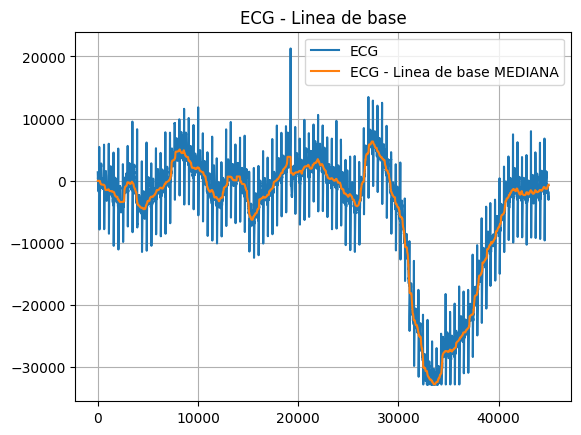

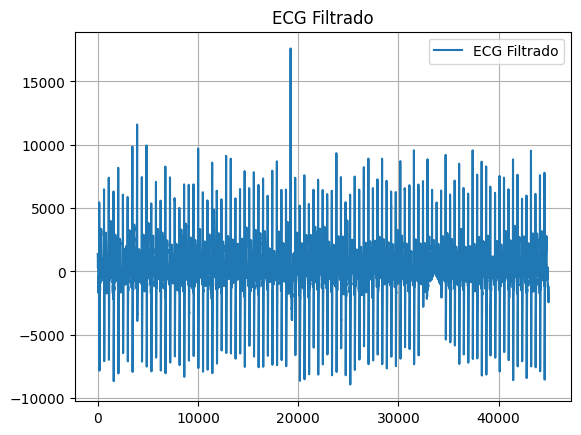

In [4]:
#%% Filtro Mediana
ecg_one_lead = ecg_one_lead[700000:745000]

#Filtro mediana 200 muestras (200ms)
ecgfiltered_1 = sig.medfilt(ecg_one_lead, kernel_size=201)

#Filtro mediana 600 muestras (600ms)
ecgfiltered_2 = sig.medfilt(ecgfiltered_1, kernel_size=601)

#Plots
plt.figure()
plt.plot(ecg_one_lead, label = "ECG")
plt.plot(ecgfiltered_2, label = "ECG - Linea de base MEDIANA")
plt.title ("ECG - Linea de base")
plt.grid();
plt.legend();

ECGfiltrado = ecg_one_lead - ecgfiltered_2

#Plots
plt.figure()
plt.plot(ECGfiltrado, label = "ECG Filtrado")
plt.title ("ECG Filtrado")
plt.grid();
plt.legend();

Filtro Splines Cubicos

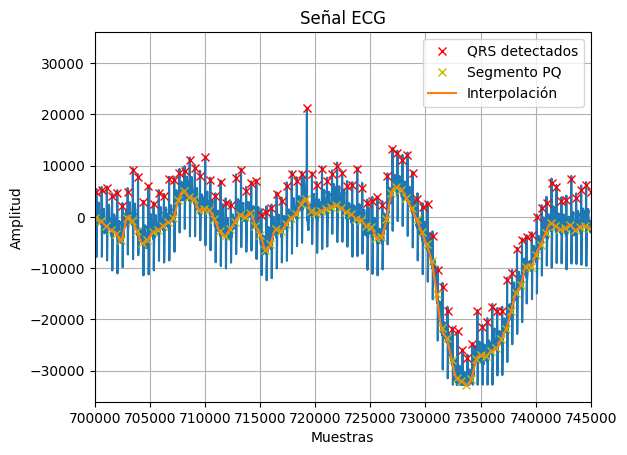

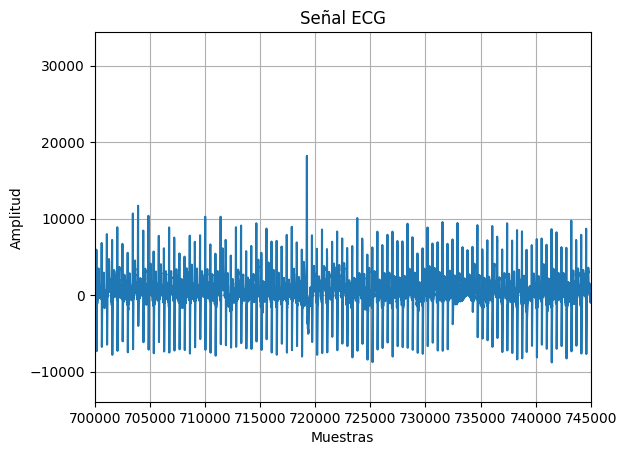

In [5]:
#%% Filtro splines cuicos
from scipy.interpolate import CubicSpline

ecg_one_lead = mat_struct['ecg_lead'].flatten()

qrs = mat_struct['qrs_detections']

qrs2 = qrs - 90 #Resto 90 ms

qrs2 = qrs2.flatten()

splines = CubicSpline(qrs2,ecg_one_lead[qrs2])

plt.figure()
plt.plot(ecg_one_lead)
plt.plot(qrs, ecg_one_lead[qrs],'rx', label='QRS detectados')
plt.plot(qrs2, ecg_one_lead[qrs2],'yx', label='Segmento PQ')
plt.plot(splines(np.arange(len(ecg_one_lead))), label='Interpolación')
plt.title('Señal ECG')
plt.xlabel('Muestras')
plt.ylabel('Amplitud')
plt.xlim(700000 , 745000)
plt.legend()
plt.grid()
plt.show()


ECGfiltrado = ecg_one_lead - splines(np.arange(len(ecg_one_lead)))

plt.figure()
plt.plot(ECGfiltrado)
plt.title('Señal ECG')
plt.xlabel('Muestras')
plt.ylabel('Amplitud')
plt.xlim(700000 , 745000)
plt.grid()
plt.show()

Detección de picos

Sensibilidad (Se): 0.949
Valor predictivo positivo (PPV): 1.000
Cantidad de detecciones verdaderas: 93
Cantidad de picos reales en la región: 98
Cantidad de picos detectados en la región: 93


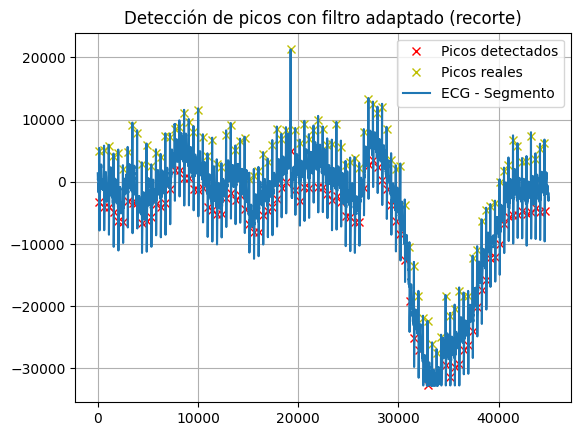

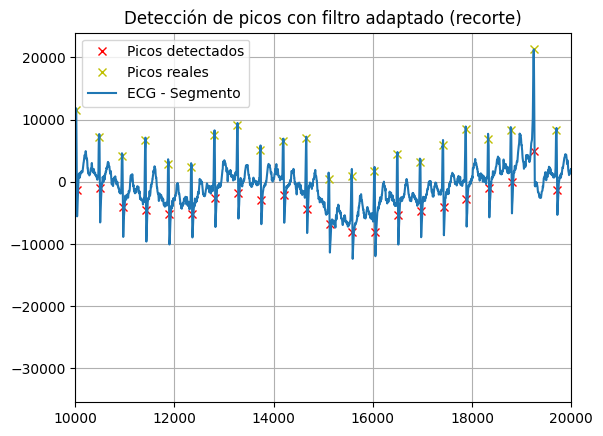

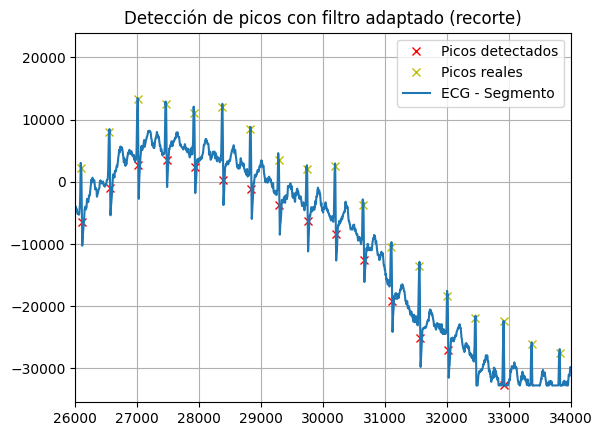

In [8]:
#%% Detección de picos (recortado entre 700000 y 745000)
fs = 1000

qrs = mat_struct['qrs_pattern1'] / np.std(mat_struct['qrs_pattern1'])

# Correlación como filtro adaptado
correlatedECG = np.correlate(ecg_one_lead, qrs.flatten(), mode='same')
correlatedECG = correlatedECG / np.std(correlatedECG)

# Recorte entre 700000 y 745000
inicio = 700000
fin = 745000
ecg_segment = ecg_one_lead[inicio:fin]
correlated_segment = correlatedECG[inicio:fin]

# Picos reales dentro del rango
peaks_true = mat_struct['qrs_detections'].flatten()
peaks_true_region = peaks_true[(peaks_true >= inicio) & (peaks_true <= fin)] - inicio

# Detección de picos dentro del segmento
peaks, _ = sig.find_peaks(correlated_segment, prominence=1.5)

# Visualización de los picos detectados
plt.figure()
plt.plot(peaks, ecg_segment[peaks], 'rx', label="Picos detectados")
plt.plot(peaks_true_region, ecg_segment[peaks_true_region], 'yx', label="Picos reales")
plt.plot(ecg_segment, label="ECG - Segmento")
plt.title("Detección de picos con filtro adaptado (recorte)")
plt.grid()
plt.legend()

# Visualización de los picos detectados
plt.figure()
plt.plot(peaks, ecg_segment[peaks], 'rx', label="Picos detectados")
plt.plot(peaks_true_region, ecg_segment[peaks_true_region], 'yx', label="Picos reales")
plt.plot(ecg_segment, label="ECG - Segmento")
plt.title("Detección de picos con filtro adaptado (recorte)")
plt.xlim(10000, 20000)
plt.grid()
plt.legend()

# Visualización de los picos detectados
plt.figure()
plt.plot(peaks, ecg_segment[peaks], 'rx', label="Picos detectados")
plt.plot(peaks_true_region, ecg_segment[peaks_true_region], 'yx', label="Picos reales")
plt.plot(ecg_segment, label="ECG - Segmento")
plt.title("Detección de picos con filtro adaptado (recorte)")
plt.xlim(26000, 34000)
plt.grid()
plt.legend()


# Comparación con tolerancia
tolerancia = 150
TP = 0

true_matched = np.zeros_like(peaks_true_region, dtype=bool)

for p in peaks:
    for i, pt in enumerate(peaks_true_region):
        if not true_matched[i] and abs(p - pt) <= tolerancia:
            TP += 1
            true_matched[i] = True
            break

FN = np.sum(~true_matched)
FP = len(peaks) - TP

Se = TP / (TP + FN) if (TP + FN) > 0 else 0
PPV = TP / (TP + FP) if (TP + FP) > 0 else 0

print(f"Sensibilidad (Se): {Se:.3f}")
print(f"Valor predictivo positivo (PPV): {PPV:.3f}")
print(f"Cantidad de detecciones verdaderas: {TP}")
print(f"Cantidad de picos reales en la región: {len(peaks_true_region)}")
print(f"Cantidad de picos detectados en la región: {len(peaks)}")

# Conclusiónes

En cuanto a los metodos de filtrado no lineal vemos un buen comportamiento para ambos metodos a la hora de eliminar el movimiento de linea de base. Incluso en zonas exigentes con ruido de baja frecuencia (entre 30000 y 40000 muestras), resultando correctamente en una señal centrada en cero. 

Luego la aplicación del mathced filter para la detección de complejos QRS en la señal de ECG mostró resultados muy satisfactorios. Se detectaron correctamente 93 de los 98 picos reales presentes en el segmento analizado, lo que se traduce en una sensibilidad (Se) de 0.949, indicando que se identificó correctamente el 94.9% de los eventos reales. Además, no se observaron falsos positivos, lo que se refleja en un valor predictivo positivo (PPV) de 1.000.

Se variaron los parametros de la función "find_peaks" tales como la altura o el ancho de los picos a detectar, pero se consiguió el mejor resultado utilizando el parametro de la prominencia. Esta medida indica qué tanto sobresale un pico con respecto a su entorno. Es útil para diferenciar picos reales de fluctuaciones pequeñas debidas al ruido. Luego se definio un criterio de tolerancia visualizando graficamente las detecciones contra los picos reales.

Vemos entonces que el gráfico ilustra una alta concordancia entre los picos reales y los picos detectados, con una alineación precisa en la mayoría de los casos. Esta buena performance evidencia que el filtro adaptado es eficaz para resaltar la morfología del complejo QRS y robusto frente al ruido presente en la señal.

Sin embargo, el hecho de que algunos picos reales no hayan sido detectados sugiere que podría mejorarse la sensibilidad mediante el ajuste de umbrales o la incorporación de etapas de refinamiento posteriores al filtrado. También podriamos evaluar zonas con mayor ruido de alta frecuencia o latidos ectópicos, si bien alrededor de las 19 000 muestras tenemos uno el cual fue detecto correctamente.

En resumen, el filtro adaptado permitió una detección precisa, sin falsos positivos y con alta sensibilidad, posicionándose como una herramienta efectiva para el análisis automático de ECG.

# Bonus

¿Funcionaría el detector con un latido de otro registro o paciente?

El filtro adaptado es diseñado a partir de un complejo QRS específico, correspondiente a un segmento particular de un registro determinado. Por esta razón, dado que utilizamos la correlación de este filtro con el QRS original, su rendimiento es óptimo cuando la morfología de los latidos a detectar es muy similar a la del patrón utilizado como plantilla.

Si se aplicara este mismo filtro a un ECG perteneciente a otro paciente, o incluso a otro registro del mismo paciente, el desempeño del detector podría verse afectado. Esto se debe a que la morfología del complejo QRS puede variar considerablemente entre individuos. Además queda pendiente realizar el estudio en el registro del ECG completo, podemos ver que también ante cambios en la frecuencia cardíaca, presencia de arritmias, ruido, o diferencias en la colocación de los electrodos, también vemos al método perjudicado.

En resumen, el filtro adaptado no generaliza bien por sí solo a señales con morfologías diferentes a la del patrón original. Para extender su aplicabilidad a otros registros o pacientes, sería necesario utilizar múltiples plantillas representativas de distintas morfologías QRS, o bien implementar estrategias más flexibles, como filtrado adaptativo o métodos basados en aprendizaje automático.